# 3.4 Stacking and interpolating data

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#3.4-Stacking-and-interpolating-data" data-toc-modified-id="3.4-Stacking-and-interpolating-data-1">3.4 Stacking and interpolating data</a></span><ul class="toc-item"><li><span><a href="#3.4.1-Introduction" data-toc-modified-id="3.4.1-Introduction-1.1">3.4.1 Introduction</a></span><ul class="toc-item"><li><span><a href="#3.4.1.1-Test-your-login" data-toc-modified-id="3.4.1.1-Test-your-login-1.1.1">3.4.1.1 Test your login</a></span></li><li><span><a href="#3.4.1.2-Get-the-datasets-for-today" data-toc-modified-id="3.4.1.2-Get-the-datasets-for-today-1.1.2">3.4.1.2 Get the datasets for today</a></span></li></ul></li><li><span><a href="#3.4.2-QA-data" data-toc-modified-id="3.4.2-QA-data-1.2">3.4.2 QA data</a></span></li><li><span><a href="#3.4.2-A-time-series" data-toc-modified-id="3.4.2-A-time-series-1.3">3.4.2 A time series</a></span></li></ul></li></ul></div>

[[up to 3.0](Chapter3_1_GDAL.ipynb)]


## 3.4.1 Introduction

In this section, we will:

* develop code to produce a stacked dataset of spatio-temporal data on a grid
* interpolate over any missing data
* smooth the dataset

### 3.4.1.1 Test your login

Let's first test your NASA login:

In [11]:
import geog0111.nasa_requests as nasa_requests
from geog0111.cylog import cylog
%matplotlib inline

url = 'https://e4ftl01.cr.usgs.gov/MOTA/MCD15A3H.006/2018.09.30/' 
        
# grab the HTML information
try:
    html = nasa_requests.get(url).text
    # test a few lines of the html
    if html[:20] == '<!DOCTYPE HTML PUBLI':
        print('this seems to be ok ... ')
        print('use cylog().login() anywhere you need to specify the tuple (username,password)')
except:
    print('login error ... try entering your username password again')
    print('then re-run this cell until it works')
    cylog(init=True)

this seems to be ok ... 
use cylog().login() anywhere you need to specify the tuple (username,password)


### 3.4.1.2 Get the datasets for today

Now let's get the datasets we need for today. These files have been pre-downloaded on the UCL Geography system. They are available through:

[http://www2.geog.ucl.ac.uk/~plewis/geog0111_data](http://www2.geog.ucl.ac.uk/~plewis/geog0111_data) or [http://www2.geog.ucl.ac.uk/~ucfajlg/geog0111_data](http://www2.geog.ucl.ac.uk/~ucfajlg/geog0111_data)

but the filenames can be locally installed using [`procure_dataset()`](geog0111/geog_data.py) as demonstrated in the code block below.

**You should run this section before the class starts to save time.**

It should be quite rapid if you are on the UCL Geography system.

On a home network, it is likely to trake more than an hour as it has to fully download the files.

You are given the relevant filenames (for 2016 and 2017 `MCD15A3H` data for the tiles `h1[7-8]v0[3-4]`) in the files [`data/lai_filelist_{year}.dat.txt`](data/lai_filelist_2016.dat.txt). The datasets have been pre-downloaded for this exercise, but you need to copy then to the local filespace:

In [12]:
from geog0111.geog_data import *

destination_folder = Path('data')
if not destination_folder.exists():
        dest_path.mkdir()

# we have the filenames provided 
# in data/lai_filelist_2016.dat.txt
for year in [2016,2017]:
    control_file = f'data/lai_filelist_{year}.dat.txt'
    # read the ascii data from the file in
    filenames = open(control_file).read().split()

    # get the local files
    # set verbose=True if you want to see what is happening
    done = [procure_dataset(f,\
                verbose=False,\
                destination_folder=destination_folder) 
                                    for f in filenames]
    # done should be all True if this has worked

    # print the first 8 in the list, just to see it looks ok
    print(f'\n {year}\n','*'*len(str(year)))
    for f in filenames[:8]:
        print (f)



 2016
 ****
MCD15A3H.A2016001.h17v03.006.2016007075833.hdf
MCD15A3H.A2016001.h17v04.006.2016007074809.hdf
MCD15A3H.A2016001.h18v03.006.2016007073724.hdf
MCD15A3H.A2016001.h18v04.006.2016007073726.hdf
MCD15A3H.A2016005.h17v03.006.2016013012017.hdf
MCD15A3H.A2016005.h17v04.006.2016013011406.hdf
MCD15A3H.A2016005.h18v03.006.2016013012348.hdf
MCD15A3H.A2016005.h18v04.006.2016013012025.hdf

 2017
 ****
MCD15A3H.A2017001.h17v03.006.2017014005341.hdf
MCD15A3H.A2017001.h17v04.006.2017014005344.hdf
MCD15A3H.A2017001.h18v03.006.2017014005401.hdf
MCD15A3H.A2017001.h18v04.006.2017014005359.hdf
MCD15A3H.A2017005.h17v03.006.2017017141758.hdf
MCD15A3H.A2017005.h17v04.006.2017017141805.hdf
MCD15A3H.A2017005.h18v03.006.2017017141813.hdf
MCD15A3H.A2017005.h18v04.006.2017017141824.hdf


Now make sure you have the world borders ESRI shape file you need:

In [13]:
import requests
import shutil 
from pathlib import Path

# zip file
zipfile = 'TM_WORLD_BORDERS-0.3.zip'
# URL
tm_borders_url = f"http://thematicmapping.org/downloads/{zipfile}"
# destibnation folder
destination_folder = Path('data')

# set up some filenames
zip_file = destination_folder.joinpath(zipfile)
shape_file = zip_file.with_name(zipfile.replace('zip','shp'))

# download zip if need to
if not Path(zip_file).exists():
    r = requests.get(tm_borders_url)
    with open(zip_file, 'wb') as fp:
        fp.write (r.content)

# extract shp from zip if need to
if not Path(shape_file).exists():
    shutil.unpack_archive(zip_file.as_posix(),
                         extract_dir=destination_folder)

## 3.4.2 QA data

need to look at QA data for dataset (and/or uncertaiunty).

For example, if interpolating data, we would want to base the weight we put on any sample on the 'quality' of that sample. This will be expressed by either some QA assessment ('good', 'ok', 'bad') or some measure of uncertainty (or both).

Here, we will use the QA information in the LAI product to generate a sample weighting scheme. We shall later use this weighting for data smoothing and interpolation.

In [14]:
import gdal
import numpy as np
from pathlib import Path
from geog0111.create_blank_file import create_blank_file
from datetime import datetime

destination_folder = Path('data')
year = 2017
product = 'MCD15A3H'
version = 6
tile = 'h1[7-8]v0[3-4]'
# Luxembourg
FIPS = "LU"

tile_ = tile.replace('[','_').replace(']','_').replace('-','')+FIPS

shape_file = destination_folder.\
                 joinpath('TM_WORLD_BORDERS-0.3.shp').as_posix()

doy = 149

ipfile = destination_folder.\
                joinpath(f'{product}.A{year}{doy:03d}.{tile_}.{version:03d}').as_posix()

opfile = ipfile.replace(f'{doy:03d}.','').replace(tile,tile_)

filenames = list(destination_folder\
                .glob(f'{product}.A{year}{doy:03d}.{tile}.{version:03d}.*.hdf'))

ofiles = []
params =  ['Lai_500m', 'FparLai_QC']
for d in params:
    dataset_names = sorted([f'HDF4_EOS:EOS_GRID:'+\
                         f'"{file_name.as_posix()}":'+\
                         f'MOD_Grid_MCD15A3H:{d}'\
                            for file_name in filenames])

    spatial_file = f'{opfile}.{doy:03d}.{d}.vrt'
    clipped_file = f'{opfile}.{doy:03d}_clip.{d}.vrt'
    g = gdal.BuildVRT(spatial_file, dataset_names)
    if(g):
        del(g)
        g = gdal.Warp(clipped_file,\
                                   spatial_file,\
                                   format='VRT', dstNodata=255,\
                                   cutlineDSName=shape_file,\
                                   cutlineWhere=f"FIPS='{FIPS}'",\
                                   cropToCutline=True)
        if (g):
            del(g)
        ofiles.append(clipped_file)
print(ofiles)

['data/MCD15A3H.A2017h1_78_v0_34_LU.006.149_clip.Lai_500m.vrt', 'data/MCD15A3H.A2017h1_78_v0_34_LU.006.149_clip.FparLai_QC.vrt']


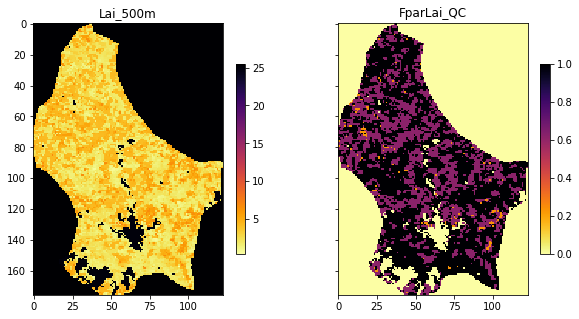

In [15]:
import matplotlib.pylab as plt
%matplotlib inline

lai = [gdal.Open(ofiles[i]).ReadAsArray() for i in range(len(params))]

lai[0] = lai[0] * 0.1
# if we want bit field 5-7
# we form a binary mask
mask57 = 0b11100000
# and right shift 5 (>> 5)
lai[1] = (lai[1] & mask57) >> 5
# 0 to 3 are good
scale = 0.61803398875
lai[1] = (scale**0) * (lai[1] == 0).astype(float) + \
         (scale**1) * (lai[1] == 1).astype(float) + \
         (scale**2) * (lai[1] == 2).astype(float) + \
         (scale**3) * (lai[1] == 3).astype(float)
    

    
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True,
                       figsize=(10,5))
axs = np.array(axs).T.flatten()

for i in range(len(params)):
    img = axs[i].imshow(lai[i], interpolation="nearest",
                 cmap=plt.cm.inferno_r)
    axs[i].set_title(params[i])
    plt.colorbar(img,ax=axs[i],shrink=0.7)

## 3.4.2 A time series

You should now know how to access and download datasets from the NASA servers and have developed functions to do this.

You should also know how to select a dataset from a set of hdf files, and mosaic, mask and crop the data to correspond to some vector boundary. This is a very common task in geospatial processing.

We now consider the case where we want to analyse a time series of data. We will use LAI over time to exemplify this.



In [16]:
import gdal
import numpy as np
from pathlib import Path
from geog0111.create_blank_file import create_blank_file
from datetime import datetime

destination_folder = Path('data')
year = 2017
product = 'MCD15A3H'
version = 6
tile = 'h1[7-8]v0[3-4]'
params =  ['Lai_500m', 'FparLai_QC']



tile_ = tile.replace('[','_').replace(']','_').replace('-','')+FIPS

shape_file = destination_folder.\
                 joinpath('TM_WORLD_BORDERS-0.3.shp').as_posix()

allopfile = destination_folder.\
                joinpath(f'{product}.A{year}.{tile_}.{version:03d}')

ndays_in_year = (datetime(year,12,31) - datetime(year,1,1)).days + 1


for d in params:
    old_clip = None
    allvrt = []
    bandNames = []
    for doy in range(1,ndays_in_year+1,1):

        ipfile = destination_folder.\
                    joinpath(f'{product}.A{year}{doy:03d}.{tile_}.{version:03d}').as_posix()

        opfile = ipfile.replace(f'{doy:03d}.','').replace(tile,tile_)

        filenames = destination_folder\
                    .glob(f'{product}.A{year}{doy:03d}.{tile}.{version:03d}.*.hdf')

        dataset_names = sorted([f'HDF4_EOS:EOS_GRID:'+\
                             f'"{file_name.as_posix()}":'+\
                             f'MOD_Grid_MCD15A3H:{d}'\
                                for file_name in filenames])
        spatial_file = f'{opfile}.{doy:03d}.{d}.vrt'
        clipped_file = f'{opfile}.{doy:03d}_clip.{d}.vrt'
        if len(dataset_names):
            g = gdal.BuildVRT(spatial_file, dataset_names)
            if(g):
                del(g)
                g = gdal.Warp(clipped_file,\
                                   spatial_file,\
                                   format='VRT', dstNodata=255,\
                                   cutlineDSName=shape_file,\
                                   cutlineWhere=f"FIPS='{FIPS}'",\
                                   cropToCutline=True)
        elif old_clip:
            blank_file_tiff = f'{opfile}_blank.tiff'
            # generate a blank dataset in case of missing days
            if not Path(blank_file_tiff).exists():
                # copy info
                create_blank_file(old_clip,blank_file_tiff,value=255)

            # build a vrt
            g = gdal.BuildVRT(clipped_file, [blank_file_tiff])

        if (g):
            del(g)
            bandNames.append(f'DOY {doy:03d}')
            allvrt.append(clipped_file)

        old_clip = clipped_file



    g = gdal.BuildVRT(f'{allopfile.as_posix()}.{d}.vrt', allvrt,\
                      options=gdal.BuildVRTOptions(VRTNodata=255,\
                                                   srcNodata=255,\
                                                   allowProjectionDifference=True,\
                                                   separate=True))
    if (g):
        # set band names
        for i in range(g.RasterCount):
            g.GetRasterBand(i+1).SetDescription(bandNames[i])

        # close and flush file
        del g
        print (f'{allopfile.as_posix()}.{d}.vrt')

data/MCD15A3H.A2017.h1_78_v0_34_LU.006.Lai_500m.vrt
data/MCD15A3H.A2017.h1_78_v0_34_LU.006.FparLai_QC.vrt


In [17]:
import gdal
import numpy as np

destination_folder = Path('data')
year = 2017
product = 'MCD15A3H'
version = 6
tile = 'h1[7-8]v0[3-4]'
params =  ['Lai_500m', 'FparLai_QC']

allopfile = destination_folder.\
                joinpath(f'{product}.A{year}.{tile_}.{version:03d}')
lai = []
for d in params:
    
    g = gdal.Open(f'{allopfile.as_posix()}.{d}.vrt',gdal.GA_ReadOnly)
    data = np.array([g.GetRasterBand(b+1).ReadAsArray() \
                for b in range(g.RasterCount)])

    lai.append(data)

lai[0] = lai[0] * 0.1
# if we want bit field 5-7
# we form a binary mask
mask57 = 0b11100000
# and right shift 5 (>> 5)
lai[1] = (lai[1] & mask57) >> 5
# 0 to 3 are good
scale = 0.61803398875
lai[1] = (scale**0) * (lai[1] == 0).astype(float) + \
         (scale**1) * (lai[1] == 1).astype(float) + \
         (scale**2) * (lai[1] == 2).astype(float) + \
         (scale**3) * (lai[1] == 3).astype(float)
    
print(lai[0].shape)

(365, 176, 123)


/Users/plewis/anaconda/envs/geog0111/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


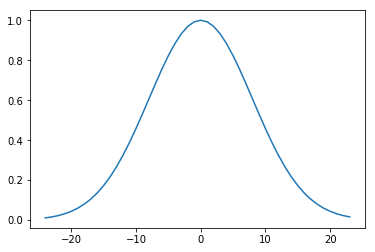

In [18]:
# interpolate
import scipy.ndimage.filters
import matplotlib.pylab as plt
%matplotlib inline

weight = lai[1]

# filter, in units of days
sigma = 8
gx = np.arange(-3*sigma, 3*sigma, 1)
gaussian = np.exp(-(gx/sigma)**2/2.)
plt.plot(gx,gaussian)
x = scipy.ndimage.filters.convolve1d(lai[0] * weight, gaussian, axis=0,mode='wrap')
w = scipy.ndimage.filters.convolve1d(weight, gaussian, axis=0,mode='wrap')
ilai = x/w

(0, 6)

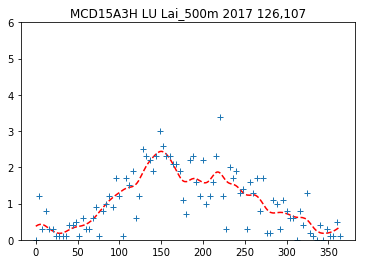

In [19]:
## find where the weight is highest, and lets look there!
sweight = weight.sum(axis=0)
r,c = np.where(sweight == np.max(sweight))
plt.title(f'{product} {FIPS} {params[0]} {year} {r[0]},{c[0]}')
plt.plot((ilai)[:,r[0],c[0]],'r--')
plt.plot((lai[0])[:,r[0],c[0]],'+')
plt.ylim(0,6)

making movie

In [ ]:
import imageio
import tempfile

# lai movie as animated gif

destination_folder = Path('images')
year = 2017
product = 'MCD15A3H'
version = 6
tile = 'h1[7-8]v0[3-4]'
params =  ['Lai_500m', 'FparLai_QC']

tile_ = tile.replace('[','_').replace(']','_').replace('-','')+FIPS
allopfile = destination_folder.\
                joinpath(f'{product}.A{year}.{tile_}.{version:03d}')

images = []
with tempfile.TemporaryDirectory() as tmpdirname:
    ofile = f'{tmpdirname}/tmp.png'
    
    for i in range(ilai.shape[0]):
        plt.figure(0,figsize=(10,6))
        plt.clf()
        plt.imshow(ilai[i],vmin=0,vmax=6,cmap=plt.cm.inferno_r)
        plt.title(f'{product} {FIPS} {params[0]} {year} DOY {i+1:03d}')
        plt.colorbar(shrink=0.85)
        plt.savefig(ofile)    
        images.append(imageio.imread(ofile))
imageio.mimsave(f'{allopfile}.gif', images)
print(f'{allopfile}.gif')

![](images/MCD15A3H.A2017.h1_78_v0_34_LU.006.gif)

